Primero se descarga el dataset usando la API de kaggle y se descomprime.

Luego se copia el cache de los tamannos de imagenes

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!pip install rasterio
!pip install opencv-python
!pip install tensorflow
!pip install h5py


In [ ]:
import cv2
import matplotlib.pyplot as plt
import h5py
import numpy as np
import os
import tensorflow as tf
import json

metrics.py


In [38]:
from keras import backend as K

smooth_default = 1e-12

def jacc_coef(y_true, y_pred, smooth = smooth_default):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) - intersection + smooth)

def dice_coef(y_true, y_pred, smooth = smooth_default, per_batch = True):
    if not per_batch:
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    else:
        y_true_f = K.batch_flatten(y_true)
        y_pred_f = K.batch_flatten(y_pred)
        intersec = 2. * K.sum(y_true_f * y_pred_f, axis=1, keepdims=True) + smooth
        union = K.sum(y_true_f, axis=1, keepdims=True) + K.sum(y_pred_f, axis=1, keepdims=True) + smooth
        return K.mean(intersec / union)

def jacc_loss(y_true, y_pred):
    return 1.0 - jacc_coef(y_true, y_pred)

acc = tf.keras.metrics.BinaryAccuracy(threshold=0.6)

def sensitivity(y_true, y_pred, threshold=0.6, smooth=smooth_default):
    true = tf.cast(y_true, tf.float32)
    pred = tf.cast(y_pred > threshold, tf.float32)

    f_true = K.batch_flatten(true)
    f_pred = K.batch_flatten(pred)
    TP = K.sum(f_true * f_pred, axis=1, keepdims=True)
    f_pred = 1.0 - f_pred
    FN = K.sum(f_true * f_pred, axis=1, keepdims=True)

    return (TP + smooth) / (FN + TP + smooth)

def specificity(y_true, y_pred, threshold=0.6, smooth=smooth_default):
    true = tf.cast(y_true, tf.float32)
    pred = tf.cast(y_pred > threshold, tf.float32)

    f_true = K.batch_flatten(true)
    f_pred = K.batch_flatten(pred)
    f_true = 1.0 - f_true

    FP = K.sum(f_true * f_pred, axis=1, keepdims=True)
    f_pred = 1.0 - f_pred
    TN = K.sum(f_true * f_pred, axis=1, keepdims=True)

    return (TN + smooth) / (TN + FP + smooth)

Modelo

In [39]:
from keras import Input, Model
from keras import layers
from keras.optimizers import Adam

ISZ = 160
CH = 3

def get_unet():
    inputs = Input(shape=(ISZ, ISZ, CH))
    conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu', data_format='channels_last')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv1)

    pool1 = layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)
    conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu', data_format='channels_last')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv2)

    pool2 = layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)
    conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu', data_format='channels_last')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv3)

    pool3 = layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)
    conv4 = layers.Conv2D(256, (3, 3), padding='same', activation='relu', data_format='channels_last')(pool3)
    conv4 = layers.Conv2D(256, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv4)

    pool4 = layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)
    conv5 = layers.Conv2D(512, (3, 3), padding='same', activation='relu', data_format='channels_last')(pool4)
    conv5 = layers.Conv2D(512, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv5)

    up5 = layers.UpSampling2D(size=(2, 2), data_format='channels_last')(conv5)
    up5 = layers.concatenate([conv4, up5])
    conv6 = layers.Conv2D(256, (3, 3), padding='same', activation='relu', data_format='channels_last')(up5)
    conv6 = layers.Conv2D(256, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv6)

    up6 = layers.UpSampling2D(size=(2, 2), data_format='channels_last')(conv6)
    up6 = layers.concatenate([conv3, up6])
    conv7 = layers.Conv2D(128, (3, 3), padding='same', activation='relu', data_format='channels_last')(up6)
    conv7 = layers.Conv2D(128, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv7)

    up7 = layers.UpSampling2D(size=(2, 2), data_format='channels_last')(conv7)
    up7 = layers.concatenate([conv2, up7])
    conv8 = layers.Conv2D(64, (3, 3), padding='same', activation='relu', data_format='channels_last')(up7)
    conv8 = layers.Conv2D(64, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv8)

    up8 = layers.UpSampling2D(size=(2, 2), data_format='channels_last')(conv8)
    up8 = layers.concatenate([conv1, up8])
    conv9 = layers.Conv2D(32, (3, 3), padding='same', activation='relu', data_format='channels_last')(up8)
    conv9 = layers.Conv2D(32, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv9)

    model = layers.Conv2D(1, (1,1), activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=model)
    model.compile(optimizer = Adam(learning_rate=1e-5), loss = 'binary_crossentropy',
                  metrics = ['accuracy', acc, jacc_loss, dice_coef, jacc_coef, sensitivity, specificity])
    return model

#model = get_unet()
#model.summary()

Código de apoyo de Leo

In [40]:

def load_dataset(path):
    f = h5py.File(path, 'r')
    X_train = f['cities_train']
    y_train = f['cities_train_mask']
    X_val = f['not_cities_train']
    y_val = f['not_cities_train_mask']
    train_ids = f['city_ids']
    val_ids = f['not_city_ids']

    return X_train, y_train, train_ids, X_val, y_val, val_ids  ####################################

def create_and_load(model_creator, weights_path):
    model = model_creator()
    model.load_weights(weights_path)
    return model

def make_prediction(model,X_train, index_index, x,y):
    ori_img = X_train[index_index]
    ori_img = ori_img.transpose(1,2,0)
    mask = model.predict(np.array([ori_img[x:x + 160,y:y + 160,:]]))
    return mask[0,:,:,0]



In [41]:
X_train, y_train, train_ids, X_val, y_val, val_ids = load_dataset('/content/drive/MyDrive/splited_train_rgb.h5')
model = create_and_load(get_unet, '/content/drive/MyDrive/last_weight.hdf5')



In [42]:
def get_img(X_train,index,x,y):
  img = X_train[index]
  img = img.transpose(1,2,0)[x:x + 160,y:y + 160,:]
  return img

def get_mask(y_train,index,x,y):
  real = y_train[index]#####################################
  real = real[x:x + 160,y:y + 160]
  return real



In [43]:
def get_all_predictions(model,X_train,y_train):
  l1, l2, l3, l4 = X_train.shape
  l1=1  ####borrar
  # l3=400   ###borrar
  # l4=400   ####borrar

  predictions:dict={}
  for i in range(l1):
    predictions[i] = {}
    x=0
    while(x<l3):
      predictions[i][x]={}
      y=0
      rx = x
      if l3-160 < x:
        x = l3-160

      while(y<l4):
        ry = y
        if l4-160 < y:
          y = l4-160

        prediction = make_prediction(model,X_train, i , x,y)

        if rx != x:
          prediction = prediction[rx-x:,:]

        if ry != y:
          prediction = prediction[:,ry-y:]

        predictions[i][rx][ry] = prediction

        if ry != y:
          break
        y+=160

      if rx != x:
        break
      x+=160

  return predictions



Las predicciones se guardan en un diccionario que tiene como primera llave `img_id` o lo que sería la imagen actual, este valor es nuevamente un diccionario que tiene como llave la coordenada `x` del punto `x_0` en el que se comienza este fragmento de la imagen y este igualmente tiene como valor un diccionario cuya llave es la coordenada `y` del punto `y_0` en el que se comienza este fragmento de la imagen, para finalmente obtener la máscara de la predicción de la imagen `img_id` que comienza en `(x_0,y_0)`

In [44]:
predictions_cities_train = get_all_predictions(model,X_train,y_train)


1/1 [==============================] - 0s 310ms/step


In [45]:
predictions_not_cities_val = get_all_predictions(model,X_val,y_val)


1/1 [==============================] - 0s 245ms/step


In [ ]:
!pip install -U scikit-learn

In [47]:
from sklearn.metrics import confusion_matrix


def bit_matrix(pred, threshold = 0.5):
  r,c=pred.shape
  for i in range(r):
    for j in range(c):
      pred[i][j]=1 if pred[i][j] >= threshold else 0
  return pred


def confusion_matrix_s(predictions:list,reals:list):
  confusion_matrixs = []
  for i in range(len(predictions)):
    if len(reals[i])== len(predictions[i]):
      confusion_matrixs.append(confusion_matrix(y_true=reals[i], y_pred= predictions[i]))
  return confusion_matrixs




In [48]:
predictions = []
reals=[]
for i in predictions_cities_train.keys():
  for x in predictions_cities_train[i].keys():
    for y in predictions_cities_train[i][x].keys():
      predictions.append(bit_matrix(predictions_cities_train[i][x][y], 0.3).flatten().tolist())
      reals.append(get_mask(y_train,i,x,y).flatten().tolist())

cm = confusion_matrix_s(predictions,reals)
cmm = np.zeros((2,2))

for i in cm:
  cmm += i
cmm = [cmm]


#### Metodo para crear una mascara con todas las predicciones de una misma imagen

In [ ]:
X=3345
Y=3338

def get_predictions_mask_for_one_image(model, i:int,pred:dict):
  join_all = np.zeros((X,Y))

  for x in pred[i].keys():
    for y in pred[i][x].keys():
      r,c=pred[i][x][y].shape
      for v in range(r):
        for w in range(c):
          join_all[v+x][w+y] = pred[i][x][y][v][w]
  return join_all


In [ ]:
p = get_predictions_mask_for_one_image(model, i=0,pred=predictions_cities_train)

print(p.shape,p)


In [ ]:

r= y_train[0]
p = [bit_matrix(p, 0.3).flatten().tolist()]
r = [r.flatten().tolist()]



In [52]:
cm_all = confusion_matrix_s(p,r)

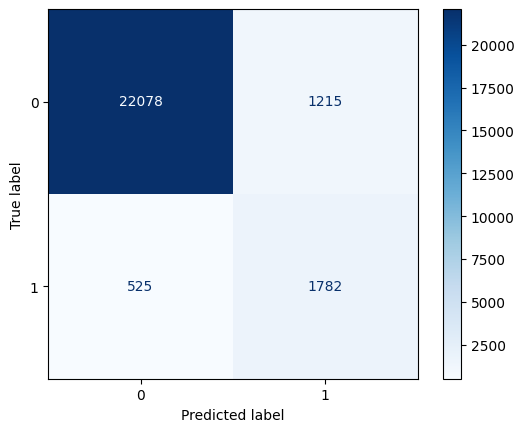

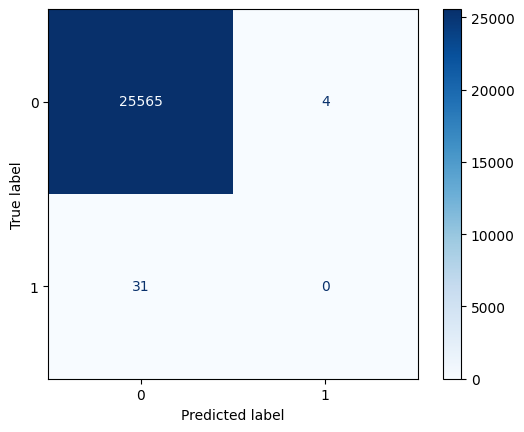

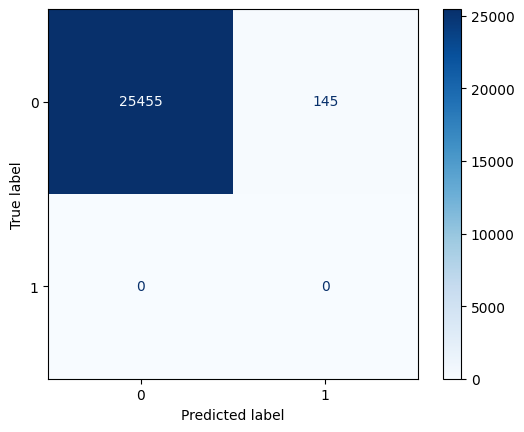

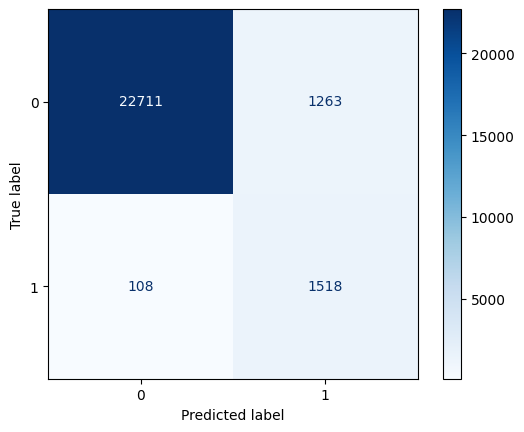

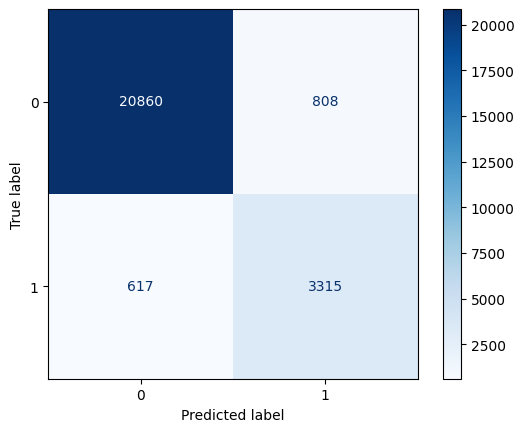

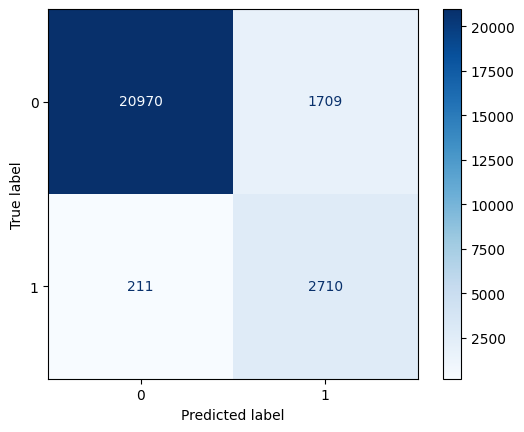

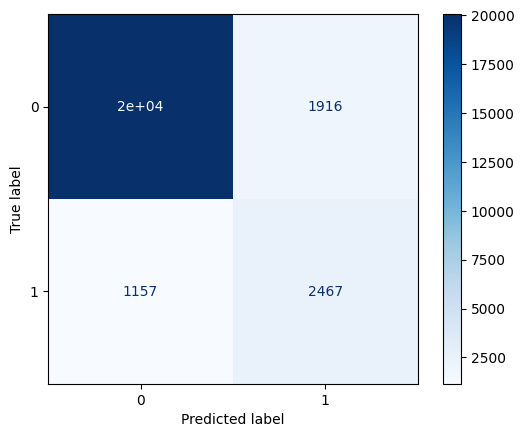

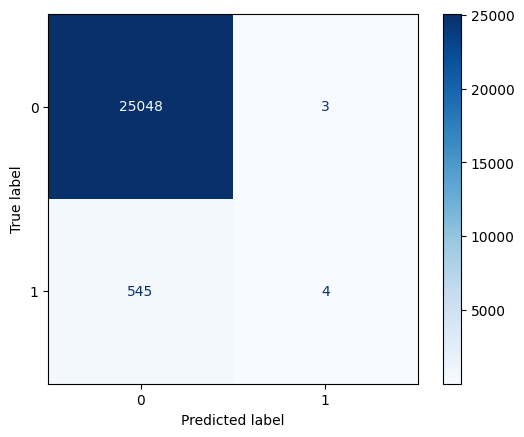

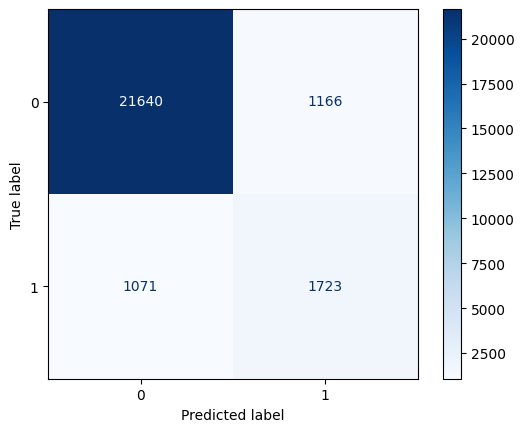

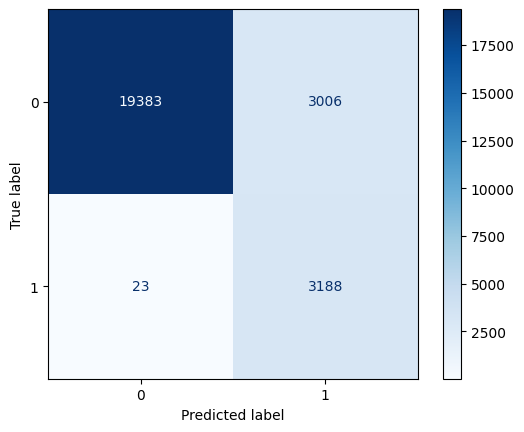

In [ ]:
# Esta es mia
from sklearn.metrics import ConfusionMatrixDisplay

for confusion_matrix_s in cm:
  confusionMatrixDisplay = ConfusionMatrixDisplay(
      confusion_matrix = confusion_matrix_s
  )

  confusionMatrixDisplay.plot(cmap="Blues")
  plt.show()

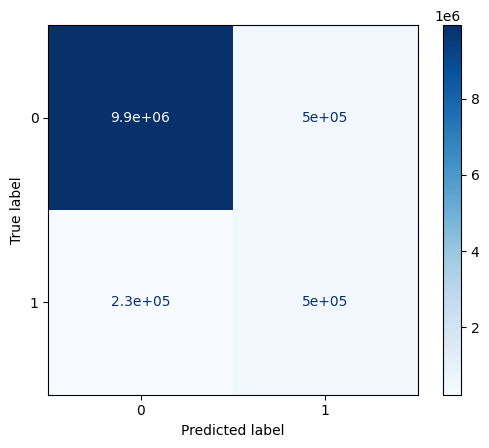

In [60]:
for confusion_matrix_s in cmm:
  confusionMatrixDisplay = ConfusionMatrixDisplay(
      confusion_matrix = confusion_matrix_s
  )

  confusionMatrixDisplay.plot(cmap="Blues")
  plt.show()

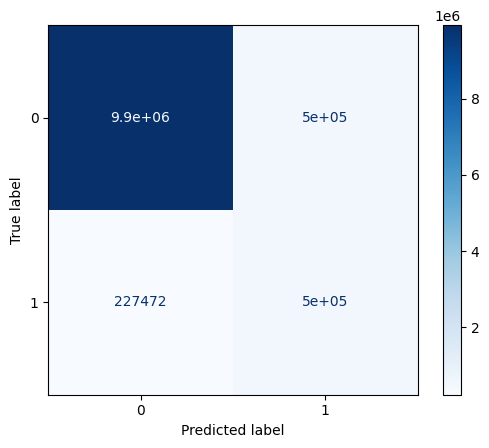

In [59]:
for confusion_matrix_s in cm_all:
  confusionMatrixDisplay = ConfusionMatrixDisplay(
      confusion_matrix = confusion_matrix_s
  )

  confusionMatrixDisplay.plot(cmap="Blues")
  plt.show()

In [80]:
def calculate_metrics(confusion_matrix):
    # Calculate precision, recall, and F1-score from the confusion matrix
    tp = confusion_matrix[1,1]
    fp = confusion_matrix[0,1]
    tn = confusion_matrix[0,0]
    fn = confusion_matrix[1,0]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)

    return precision, recall, f1_score

def plot_scores(model_names, precision_scores, recall_scores, f1_scores):
    # Crear figura y ejes
    fig, ax = plt.subplots()

    # Crear barras para las medidas de precisión, recobrado y F1-score
    bar_width = 0.25
    bar_positions = np.arange(len(model_names))
    ax.bar(bar_positions, precision_scores, width=bar_width, label='Precisión')
    ax.bar(bar_positions + bar_width, recall_scores, width=bar_width, label='Recobrado')
    ax.bar(bar_positions + 2*bar_width, f1_scores, width=bar_width, label='F1-score')

    # Añadir etiquetas de modelo y leyenda
    ax.set_xticks(bar_positions + bar_width)
    ax.set_xticklabels(model_names)
    ax.legend()

    # Mostrar la figura
    plt.show()

In [64]:
cm_all[0][0,1]

497941

Precision: 0.5033720842093504
Recall: 0.689320176187387
F1-score: 0.5818509020249374


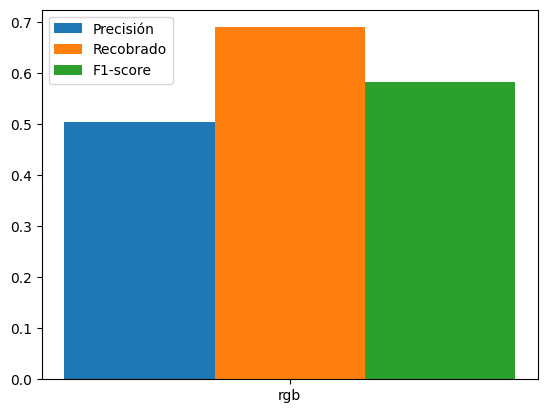

In [81]:
for confusion_matrix_s in cm_all:
  precision, recall, f1_score = calculate_metrics(confusion_matrix_s)


  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1_score)
  plot_scores(["rgb"], [precision], [recall], [f1_score])

In [ ]:
# # Crear datos de ejemplo para los modelos
# model_names = ['Modelo A', 'Modelo B', 'Modelo C']
# precision_scores = [0.8, 0.7, 0.9]
# recall_scores = [0.7, 0.8, 0.6]
# f1_scores = [0.75, 0.75, 0.75]

# # Graficar las medidas para los modelos utilizando el método plot_scores
# plot_scores(model_names, precision_scores, recall_scores, f1_scores)

